# Plateforme Agnostique de Traitement et d'Analyse des Textes
### Carnet d'expérimentation
---

## Sujet : Pytorch


---

# Initialisations
---

In [1]:
_rs = 42

In [2]:
cd ../..

/Volumes/Geek/Work/Patat


In [3]:
import ast
import importlib
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
tqdm.pandas()

# Préparation Données

---

## Chargement

In [4]:
import patat.util.file

filename = 'data/tmp/230603-df_ml.pickle'

df_ml = patat.util.file.pickle_load(filename)

stopwords = patat.util.file.pickle_load('data/tmp/stopwords.pickle')

# Experience
---

## Preprocessing

In [5]:
import patat.util.text

In [6]:
import re

In [7]:
def preprocess(text):
    text = patat.util.text.preprocess(text)
    # Remove numbers
    text = re.sub(r'\d+','',text)
    return text

In [8]:
df_ml['text_p']=df_ml['text'].apply(preprocess)

## Mono Perceptron

In [11]:
import numpy as np
import torch
import torch.nn as nn
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f'device : {device}')

device : mps


### 0. Prepare data

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.pipeline import Pipeline, make_pipeline

In [14]:
sw = stopwords

In [15]:
vectorizer = TfidfVectorizer(stop_words=sw)

In [16]:
X = vectorizer.fit_transform(df_ml['text']).toarray()
y = df_ml['infox']

In [17]:
from sklearn.model_selection import train_test_split

n_samples, n_features = X.shape

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=_rs)

In [18]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.values.astype(np.float32))
y_test = torch.from_numpy(y_test.values.astype(np.float32))

y_train = y_train.view(y_train.shape[0], 1)
y_test = y_test.view(y_test.shape[0], 1)

### 1. Model

In [30]:
# Linear model f = wx + b , sigmoid at the end
class LRModel(nn.Module):
    
    _nb_hidden = 3
    
    def __init__(self, n_input_features):
        super(LRModel, self).__init__()
        self.linear = nn.Linear(n_input_features, 1)
#        self.linear = nn.Linear(n_input_features, self._nb_hidden)
#        self.relu = nn.ReLU(self._nb_hidden)
#        self.hidden = nn.Linear(self._nb_hidden, 1)

    def forward(self, x):
        y_pred = self.linear(x)
#        y_pred = self.relu(y_pred)
#        y_pred = self.hidden(y_pred)
        y_pred = torch.sigmoid(y_pred)
        return y_pred

model = LRModel(n_features)
model.to(device)

LRModel(
  (linear): Linear(in_features=44807, out_features=1, bias=True)
)

### 2. Loss and optimizer

In [31]:
num_epochs = 10000
learning_rate = 0.01
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### 3. Training loop - MPS

In [32]:
from sklearn import metrics

In [33]:
X_train=X_train.to(device)
X_test=X_test.to(device)
y_train=y_train.to(device)
y_test=y_test.to(device)

In [34]:
%%time
scores=[]
for epoch in tqdm(range(num_epochs)):
    # Forward pass and loss
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)

    # Backward pass and update
    loss.backward()
    optimizer.step()

    # zero grad before new step
    optimizer.zero_grad()

    if (epoch+1) % 500 == 0:
        with torch.no_grad():
            y_predicted = model(X_test)
            y_predicted_cls = y_predicted.round()
            pred = y_predicted.to('cpu').T.numpy().round()[0]
            proba = y_predicted.to('cpu').T.numpy()[0]
            true = y_test.to('cpu').T.numpy()[0]

            accuracy = metrics.accuracy_score(true,pred)
            f1 = metrics.f1_score(true,pred)
            recall = metrics.recall_score(true,pred)
            roc_auc = metrics.roc_auc_score(true,proba)
            scores.append({
                'epoch': epoch+1,
                'loss': float(loss),
                'accuracy': accuracy,
                'f1': f1,
                'recall': recall,
                'roc_auc': roc_auc,
            })

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 4.98 s, sys: 490 ms, total: 5.47 s
Wall time: 8.29 s


### Metriques

<Axes: xlabel='epoch'>

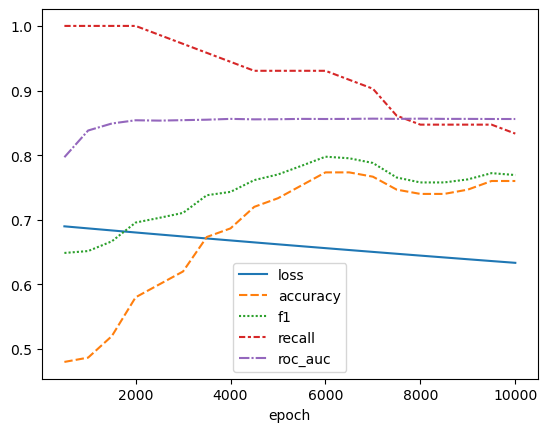

In [35]:
df_scores = pd.DataFrame(scores).set_index('epoch')
sns.lineplot(df_scores)

In [36]:
pd.set_option('display.precision',3)
df_scores

,loss,accuracy,f1,recall,roc_auc
epoch,,,,,
500,0.690,0.480,0.649,1.000,0.797
1000,0.687,0.487,0.652,1.000,0.838
1500,0.683,0.520,0.667,1.000,0.849
2000,0.680,0.580,0.696,1.000,0.854
2500,0.677,0.600,0.703,0.986,0.853
3000,0.674,0.620,0.711,0.972,0.854
3500,0.671,0.673,0.738,0.958,0.855
4000,0.668,0.687,0.743,0.944,0.856
4500,0.665,0.720,0.761,0.931,0.855


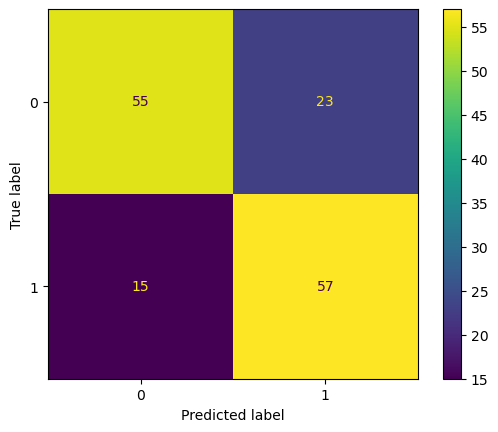

In [26]:
cm = metrics.confusion_matrix(true, pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## Sklearn Logistic Regression

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [ ]:
%%time
classifier = LogisticRegression(C=15, random_state=_rs, solver='lbfgs', multi_class='ovr', max_iter=1000)
scores = cross_validate(classifier, embeddings, labels, cv=5,scoring=('balanced_accuracy','f1_weighted','recall','precision','roc_auc'))
df_scores=pd.DataFrame(scores)
df_scores.mean()

In [ ]:
metrics.get_scorer_names()

In [ ]:
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import roc_curve, balanced_accuracy_score, accuracy_score

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=42)

In [ ]:
classifier.fit(X_train,y_train)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_train,classifier.predict_proba(X_train)[:,1],drop_intermediate=False)

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(thresholds,np.abs(fpr+tpr-1))
plt.xlabel("Threshold")
plt.ylabel("|FPR + TPR - 1|")
plt.show()

In [ ]:
thresholds[np.argmin(np.abs(fpr+tpr-1))]

In [ ]:
threshold = []
accuracy = []

for p in np.unique(classifier.predict_proba(X_train)[:,1]):
    threshold.append(p)
    y_pred = (classifier.predict_proba(X_train)[:,1] >= p).astype(int)
    accuracy.append(accuracy_score(y_train,y_pred))

In [ ]:
plt.scatter(threshold,accuracy)
plt.xlabel("Threshold")
plt.ylabel("Balanced accuracy")
plt.show()

In [ ]:
threshold[np.argmax(accuracy)]

# Conclusions
---